<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
!pip install japanize-matplotlib | tail -n 1
!pip install plotly | tail -n 1

元データ (150, 4) (150,)
対象データ (150, 4) (150,)


学習データ： torch.Size([75, 4]) torch.Size([75])
検証データ： torch.Size([75, 4]) torch.Size([75])
n_input:4, n_output:3
weight
 Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)
bias
 Parameter containing:
tensor([1., 1., 1.], requires_grad=True)


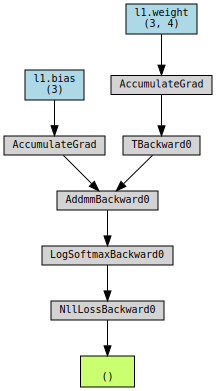

初期状態: 損失: 1.09158 精度: 0.26667
最終状態: 損失: 0.13724 精度: 0.96000


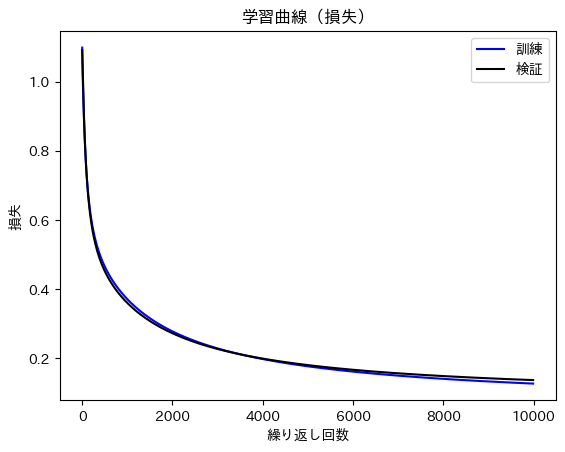

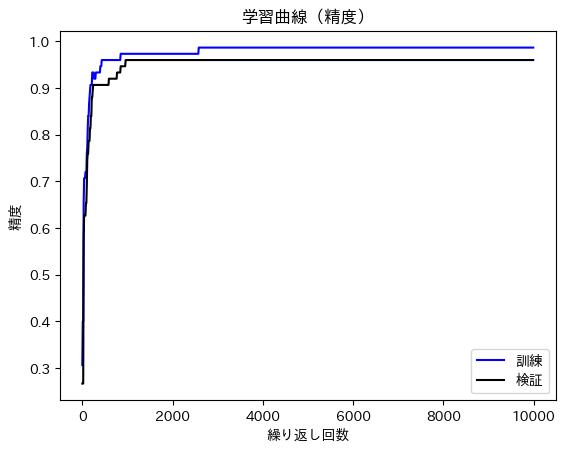

weight:  Parameter containing:
tensor([[ 1.8991, -1.8499,  3.0917, -0.3448],
        [ 1.5797,  0.9194,  1.1379, -0.1347],
        [-0.4789,  3.9305, -1.2295,  3.4794]], requires_grad=True)
bias:  Parameter containing:
tensor([1.4016, 1.5386, 0.0597], requires_grad=True)


In [5]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torchinfo import summary
from torchviz import make_dot
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# データ準備
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target
print('元データ', x_org.shape, y_org.shape)

# データ絞り込み
#  項目 sepal_lengthとpetal_widthと + 1
#  クラス 0,1,2(0～150行目)
x_data = iris.data[:150, [0, 2, 1, 3]]
y_data = iris.target[:150]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)
x0 = x_data[y_data == 0]
x1 = x_data[y_data == 1]
x2 = x_data[y_data == 2]
data0 = go.Scatter(x=x0[:,0], y=x0[:,1],
                    mode='markers',
                    name='0(setosa)')
data1 = go.Scatter(x=x1[:,0], y=x1[:,1],
                    mode='markers',
                    name='1(versicolor)')
data2 = go.Scatter(x=x2[:,0], y=x2[:,1],
                    mode='markers',
                    name='2(virginica)')
fig = go.Figure()
fig.add_trace(data0)
fig.add_trace(data1)
fig.add_trace(data2)
# X軸タイトルを指定
fig.update_xaxes(title="sepal_length",
                 color='grey',
                 ticks='inside',
                 ticklen=5,
                 tickwidth=2,
                 tickcolor='lightgrey'
                 )
fig.update_yaxes(title="petal_width") # Y軸タイトルを指定
fig.update_layout(title="散布図（訓練データ）") # グラフタイトルを設定
fig.update_layout(showlegend=True) # 凡例を強制的に表示（デフォルトでは複数系列あると表示）
fig.show()

# 訓練データ、検証データに分割（シャッフルも同時に実施）
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=75, test_size=75,
    random_state=123
)

###################################################
# 関数定義
###################################################
lr = 0.01  # 学習率
num_epochs = 10000 # 繰り返し回数
num_history = 10 # 履歴採取タイミング

# 学習データ
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証データ
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

print('学習データ：',inputs.shape, labels.shape)
print('検証データ：',inputs_test.shape, labels_test.shape)

# 予測計算クラス
n_input = x_train.shape[1]
n_output = len(list(set(y_train)))
print(f'n_input:{n_input}, n_output:{n_output}')
class Net(torch.nn.Module):
  # 初期化
  def __init__(self, n_input, n_output):
    super().__init__()
    # 予測関数を生成
    self.l1 = torch.nn.Linear(n_input, n_output) # 初段

    # 重み、バイアスの初期値を設定
    self.l1.weight.data.fill_(1.0)
    self.l1.bias.data.fill_(1.0)
    print('weight\n', self.l1.weight)
    print('bias\n', self.l1.bias)

    # 関数合成
    self.net = torch.nn.Sequential(
        self.l1,
    )

  # 予測関数
  def forward(self, inputs):
    outputs = self.net(inputs)
    return outputs

# 予測計算オブジェクト
net = Net(n_input, n_output)

# 損失関数
criterion = torch.nn.CrossEntropyLoss()

# 最適化関数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化
history = np.zeros((0, 5))

###################################################
# 強化学習
###################################################
for epoch in range(num_epochs):

  ###################################################
  # 学習フェーズ
  ###################################################
  # 予測計算
  outputs = net(inputs)

  # 損失計算
  loss = criterion(outputs, labels)
  if epoch == 0:
    g = make_dot(loss, params = dict(net.named_parameters()))
    display(g)
  # if epoch == num_epochs - 1:
  #   print(torch.max(outputs, 1))

  # 勾配計算
  loss.backward()

  # パラメータ調整＆勾配クリア
  optimizer.step()
  optimizer.zero_grad()

  # 損失の保存（スカラー値の取得）
  train_loss = loss.item()

  # # 予測データ（0, 1, 2）計算
  predicted = torch.max(outputs, 1)[1]

  # # 精度計算
  train_acc = (predicted == labels).sum() / len(y_train)

  ###############################################
  # 予測フェーズ
  ###############################################
  outputs_test = net(inputs_test)

  # 損失計算
  loss_test = criterion(outputs_test, labels_test)

  # 損失の保存（スカラー値の取得）
  train_loss_test = loss_test.item()
  # if epoch == num_epochs - 1:
  #   print(train_loss_test)

  # 予測データ計算
  predicted_test = torch.max(outputs_test, 1)[1]

  # 精度計算
  train_acc_test = (predicted_test == labels_test).sum() / len(y_test)

  # 学習曲線データの登録
  if epoch % num_history == 0:
    item = np.array([
        epoch,
        train_loss,
        train_acc,
        train_loss_test,
        train_acc_test])
    history = np.vstack((history, item))


###############################################
# 結果表示
###############################################
# 損失と精度の確認
print(f'初期状態: 損失: {history[0, 3]:.5f} 精度: {history[0, 4]:.5f}')
print(f'最終状態: 損失: {history[-1, 3]:.5f} 精度: {history[-1, 4]:.5f}')

# 学習曲線グラフ（損失）
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.legend()
plt.show()

# 学習曲線グラフ（精度）
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線（精度）')
plt.legend()
plt.show()

# 散布図の表示（訓練データ）
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

zero = np.zeros(x_t0.shape[0])
data1 = go.Scatter3d(x=x_t0[:,0], y=x_t0[:,1], z=x_t0[:,2],
                    mode='markers',
                    marker=dict(size=3, color='blue', opacity=0.3, symbol='circle', showscale=True),
                    name='0(setosa)(訓)')
data2 = go.Scatter3d(x=x_t1[:,0], y=x_t1[:,1], z=x_t1[:,2],
                    mode='markers',
                    marker=dict(size=3, color='red', opacity=0.3, symbol='circle', showscale=True),
                    name='1(versicolor)(訓)')
data3 = go.Scatter3d(x=x_t2[:,0], y=x_t2[:,1], z=x_t2[:,2],
                    mode='markers',
                    marker=dict(size=3, color='green', opacity=0.3, symbol='circle', showscale=True),
                    name='2(virginica)(訓)')
# 散布図の表示（予測データ）
x_e0 = x_test[y_test == 0]
x_e1 = x_test[y_test == 1]
x_e2 = x_test[y_test == 2]
data4 = go.Scatter3d(x=x_e0[:,0], y=x_e0[:,1], z=x_e0[:,2],
                    mode='markers',
                    marker=dict(size=1, color='blue', opacity=0.8, symbol='diamond', showscale=True),
                    name='0(setosa)(予)')
data5 = go.Scatter3d(x=x_e1[:,0], y=x_e1[:,1], z=x_e1[:,2],
                    mode='markers',
                    marker=dict(size=1, color='red', opacity=0.8, symbol='diamond', showscale=True),
                    name='1(versicolor)(予)')
data6 = go.Scatter3d(x=x_e2[:,0], y=x_e2[:,1], z=x_e2[:,2],
                    mode='markers',
                    marker=dict(size=1, color='green', opacity=0.8, symbol='diamond', showscale=True),
                    name='2(virginica)(予)')

# 最終パラメータ表示
print('weight: ', net.l1.weight)
print('bias: ', net.l1.bias)

# # 予測平面の表示
# x = np.outer(np.linspace(4.0, 7.0, 30), np.ones(30))
# y = np.outer(np.linspace(2.0, 4.5, 30), np.ones(30)).T
# w1 = net.l1.weight.data[0][0].item()
# w2 = net.l1.weight.data[0][1].item()
# b = net.l1.bias.data[0].item()
# z = w1 * x + w2 * y + b
# data5 = go.Surface(x=x, y=y, z=z, opacity=0.5)
fig = go.Figure()
fig.add_trace(data1)
fig.add_trace(data2)
fig.add_trace(data3)
fig.add_trace(data4)
fig.add_trace(data5)
fig.add_trace(data6)
# X軸タイトルを指定
fig.update_xaxes(title="sepal_length")
fig.update_yaxes(title="petal_width") # Y軸タイトルを指定
fig.update_layout(title="散布図（訓練データ、予測データ）と予測平面") # グラフタイトルを設定
fig.update_layout(showlegend=True) # 凡例を強制的に表示（デフォルトでは複数系列あると表示）
fig.update_layout(width=1200, height=900) # 図の高さと幅を指定
fig.update_layout(legend=dict(xanchor='center',
                              yanchor='bottom',
                              x=0.85,
                              y=0.7,
                              orientation='v',
                              bgcolor='white',
                              bordercolor='black',
                              borderwidth=0.1,
                              ))
fig.show()

元データ (150, 4) (150,)
対象データ (150, 2) (150,)


学習データ： torch.Size([75, 2]) torch.Size([75])
検証データ： torch.Size([75, 2]) torch.Size([75])
n_input:2, n_output:3
weight
 Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True)
bias
 Parameter containing:
tensor([1., 1., 1.], requires_grad=True)


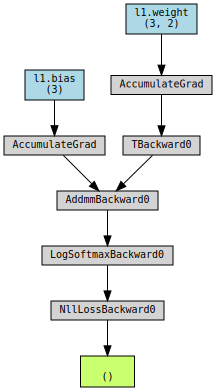

初期状態: 損失: 1.09263 精度: 0.26667
最終状態: 損失: 0.19795 精度: 0.96000


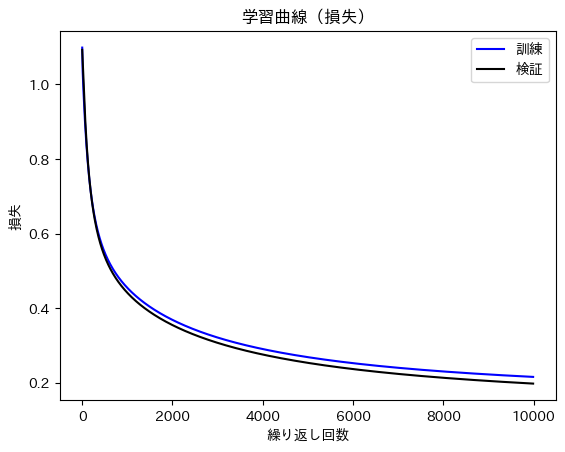

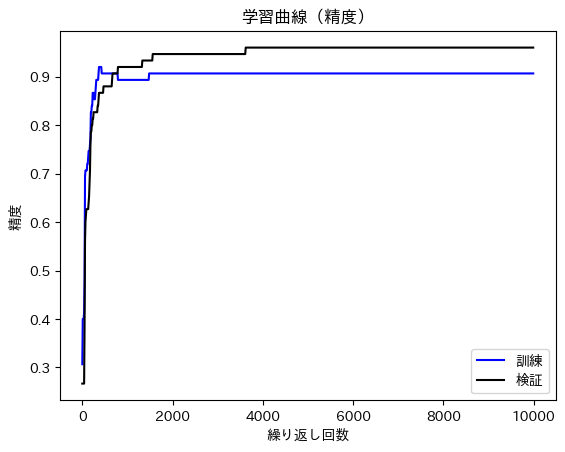

weight:  Parameter containing:
tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]], requires_grad=True)
bias:  Parameter containing:
tensor([ 1.7178,  1.6563, -0.3741], requires_grad=True)


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torchinfo import summary
from torchviz import make_dot
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# データ準備
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target
print('元データ', x_org.shape, y_org.shape)

# データ絞り込み
#  項目 sepal_lengthとpetal_width, 1, 3
#  クラス 0,1,2(0～150行目)
x_data = iris.data[:150, [0, 2, 1, 3]]
y_data = iris.target[:150]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)
x0 = x_data[y_data == 0]
x1 = x_data[y_data == 1]
x2 = x_data[y_data == 2]
data0 = go.Scatter(x=x0[:,0], y=x0[:,1],
                    mode='markers',
                    name='0(setosa)')
data1 = go.Scatter(x=x1[:,0], y=x1[:,1],
                    mode='markers',
                    name='1(versicolor)')
data2 = go.Scatter(x=x2[:,0], y=x2[:,1],
                    mode='markers',
                    name='2(virginica)')
fig = go.Figure()
fig.add_trace(data0)
fig.add_trace(data1)
fig.add_trace(data2)
# X軸タイトルを指定
fig.update_xaxes(title="sepal_length",
                 color='grey',
                 ticks='inside',
                 ticklen=5,
                 tickwidth=2,
                 tickcolor='lightgrey'
                 )
fig.update_yaxes(title="petal_width") # Y軸タイトルを指定
fig.update_layout(title="散布図（訓練データ）") # グラフタイトルを設定
fig.update_layout(showlegend=True) # 凡例を強制的に表示（デフォルトでは複数系列あると表示）
fig.show()

# 訓練データ、検証データに分割（シャッフルも同時に実施）
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=75, test_size=75,
    random_state=123
)

###################################################
# 関数定義
###################################################
lr = 0.01  # 学習率
num_epochs = 10000 # 繰り返し回数
num_history = 10 # 履歴採取タイミング

# 学習データ
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証データ
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

print('学習データ：',inputs.shape, labels.shape)
print('検証データ：',inputs_test.shape, labels_test.shape)

# 予測計算クラス
n_input = x_train.shape[1]
n_output = len(list(set(y_train)))
print(f'n_input:{n_input}, n_output:{n_output}')
class Net(torch.nn.Module):
  # 初期化
  def __init__(self, n_input, n_output):
    super().__init__()
    # 予測関数を生成
    self.l1 = torch.nn.Linear(n_input, n_output) # 初段

    # 重み、バイアスの初期値を設定
    self.l1.weight.data.fill_(1.0)
    self.l1.bias.data.fill_(1.0)
    print('weight\n', self.l1.weight)
    print('bias\n', self.l1.bias)

    # 関数合成
    self.net = torch.nn.Sequential(
        self.l1,
    )

  # 予測関数
  def forward(self, inputs):
    outputs = self.net(inputs)
    return outputs

# 予測計算オブジェクト
net = Net(n_input, n_output)

# 損失関数
criterion = torch.nn.CrossEntropyLoss()

# 最適化関数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化
history = np.zeros((0, 5))

###################################################
# 強化学習
###################################################
for epoch in range(num_epochs):

  ###################################################
  # 学習フェーズ
  ###################################################
  # 予測計算
  outputs = net(inputs)

  # 損失計算
  loss = criterion(outputs, labels)
  if epoch == 0:
    g = make_dot(loss, params = dict(net.named_parameters()))
    display(g)
  # if epoch == num_epochs - 1:
  #   print(torch.max(outputs, 1))

  # 勾配計算
  loss.backward()

  # パラメータ調整＆勾配クリア
  optimizer.step()
  optimizer.zero_grad()

  # 損失の保存（スカラー値の取得）
  train_loss = loss.item()

  # 予測データ（0, 1, 2）計算
  predicted = torch.max(outputs, 1)[1]

  # 精度計算
  train_acc = (predicted == labels).sum() / len(y_train)

  ###############################################
  # 予測フェーズ
  ###############################################
  outputs_test = net(inputs_test)

  # 損失計算
  loss_test = criterion(outputs_test, labels_test)

  # 損失の保存（スカラー値の取得）
  train_loss_test = loss_test.item()

  # 予測データ計算
  predicted_test = torch.max(outputs_test, 1)[1]

  # 精度計算
  train_acc_test = (predicted_test == labels_test).sum() / len(y_test)

  # 学習曲線データの登録
  if epoch % num_history == 0:
    item = np.array([epoch, train_loss, train_acc, train_loss_test, train_acc_test])
    history = np.vstack((history, item))


###############################################
# 結果表示
###############################################
# 損失と精度の確認
print(f'初期状態: 損失: {history[0, 3]:.5f} 精度: {history[0, 4]:.5f}')
print(f'最終状態: 損失: {history[-1, 3]:.5f} 精度: {history[-1, 4]:.5f}')

# 学習曲線グラフ（損失）
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.legend()
plt.show()

# 学習曲線グラフ（精度）
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線（精度）')
plt.legend()
plt.show()

# 散布図の表示（訓練データ）
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

zero = np.zeros(x_t0.shape[0])
data1 = go.Scatter3d(x=x_t0[:,0], y=x_t0[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=3, color='blue', opacity=0.3, symbol='circle', showscale=True),
                    name='0(setosa)(訓)')
data2 = go.Scatter3d(x=x_t1[:,0], y=x_t1[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=3, color='red', opacity=0.3, symbol='circle', showscale=True),
                    name='1(versicolor)(訓)')
data3 = go.Scatter3d(x=x_t2[:,0], y=x_t2[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=3, color='green', opacity=0.3, symbol='circle', showscale=True),
                    name='2(virginica)(訓)')
# 散布図の表示（予測データ）
x_e0 = x_test[predicted_test.data == 0]
x_e1 = x_test[predicted_test.data == 1]
x_e2 = x_test[predicted_test.data == 2]
data4 = go.Scatter3d(x=x_e0[:,0], y=x_e0[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=1, color='blue', opacity=0.8, symbol='diamond', showscale=True),
                    name='0(setosa)(予)')
data5 = go.Scatter3d(x=x_e1[:,0], y=x_e1[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=1, color='red', opacity=0.8, symbol='diamond', showscale=True),
                    name='1(versicolor)(予)')
data6 = go.Scatter3d(x=x_e2[:,0], y=x_e2[:,1], z=zero,
                    mode='markers',
                    marker=dict(size=1, color='green', opacity=0.8, symbol='diamond', showscale=True),
                    name='2(virginica)(予)')

# 最終パラメータ表示
print('weight: ', net.l1.weight)
print('bias: ', net.l1.bias)

# # 予測平面の表示
# x = np.outer(np.linspace(4.0, 7.0, 30), np.ones(30))
# y = np.outer(np.linspace(2.0, 4.5, 30), np.ones(30)).T
# w1 = net.l1.weight.data[0][0].item()
# w2 = net.l1.weight.data[0][1].item()
# b = net.l1.bias.data[0].item()
# z = w1 * x + w2 * y + b
# data5 = go.Surface(x=x, y=y, z=z, opacity=0.5)
fig = go.Figure()
fig.add_trace(data1)
fig.add_trace(data2)
fig.add_trace(data3)
fig.add_trace(data4)
fig.add_trace(data5)
fig.add_trace(data6)
# X軸タイトルを指定
fig.update_xaxes(title="sepal_length")
fig.update_yaxes(title="petal_width") # Y軸タイトルを指定
fig.update_layout(title="散布図（訓練データ、予測データ）と予測平面") # グラフタイトルを設定
fig.update_layout(showlegend=True) # 凡例を強制的に表示（デフォルトでは複数系列あると表示）
fig.update_layout(width=1200, height=900) # 図の高さと幅を指定
fig.update_layout(legend=dict(xanchor='center',
                              yanchor='bottom',
                              x=0.85,
                              y=0.7,
                              orientation='v',
                              bgcolor='white',
                              bordercolor='black',
                              borderwidth=0.1,
                              ))
fig.show()